# Plot helicity calculations

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as axisartist
import matplotlib.patches as patches

In [2]:
from scipy.constants import proton_mass as m_i
from scipy.constants import elementary_charge as q_e
import scipy.fftpack as fft
from scipy.signal import boxcar, convolve

In [3]:
date = '2017-02-23-20-05'
path = '../../output/helicity/' + date + '/'
kinetic_helicity = np.loadtxt(path + 'kinetic_helicity_raw_vorticity.txt')
kinetic_helicity_smoothed_vorticity = np.loadtxt(path + 'kinetic_helicity.txt')
cross_helicity = np.loadtxt(path + 'cross_helicity.txt')
magnetic_helicity = np.loadtxt(path + 'magnetic_helicity.txt')

relative_cross_helicity = np.loadtxt(path + 'relative_cross_helicity_raw_vorticity.txt')
relative_kinetic_helicity = np.loadtxt(path + 'relative_kinetic_helicity_raw_vorticity.txt')
relative_cross_helicity_smoothed_vorticity = np.loadtxt(path + 'relative_cross_helicity.txt')
relative_kinetic_helicity_smoothed_vorticity = np.loadtxt(path + 'relative_kinetic_helicity.txt')
relative_magnetic_helicity = np.loadtxt(path + 'relative_magnetic_helicity.txt')
time = np.arange(0, 250) * 0.068
helicities = {'kinetic': kinetic_helicity,
              'cross': cross_helicity, 
              'magnetic': magnetic_helicity,
              'relative_kinetic': relative_kinetic_helicity,
              'relative_cross': relative_cross_helicity,
              'relative_magnetic': relative_magnetic_helicity,
              'kinetic_smoothed_vorticity': kinetic_helicity_smoothed_vorticity,
              'relative_kinetic_smoothed_vorticity': relative_kinetic_helicity_smoothed_vorticity,
              'relative_cross_smoothed_vorticity': relative_cross_helicity_smoothed_vorticity,
              'time': time}

# Plot gyration path

In [14]:
def gyration_path(axes=None, circles=None, step=25):
    centroid_file = '/home/jensv/rsx/jens_analysis/output/centroid_fitting/2016-08-12/field_nulls.txt'
    field_nulls = np.loadtxt(centroid_file)

    x_min, x_max = -0.022, 0.024
    y_min, y_max = -0.017, 0.018

    if not axes:
        fig, axes = plt.subplots(1, 1)
    
    measurement_box = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min,
                                    color='grey', alpha=0.4)

    
    bx_by_x_min = -0.024
    bx_by_x_max = 0.025
    bx_by_y_min = -0.073
    bx_by_y_max = 0.041
    bx_by_measurement_box = patches.Rectangle((bx_by_x_min, bx_by_x_min), 
                                              bx_by_x_max - bx_by_x_min,
                                              bx_by_y_max - bx_by_y_min,
                                              color='grey', alpha=0.1)
    
    
    axes.add_patch(measurement_box)
    axes.add_patch(bx_by_measurement_box)
    colormap = np.linspace(0, 1, 250)
    axes.scatter(field_nulls[:, 0], field_nulls[:, 1], c=colormap)


    axes.text(-0.008, -0.015, r'$0 \mu s$')
    axes.text(0.03, -0.003, r'$%2.1f \mu s$' % (0.068*56))
    axes.text(-0.03, 0.017, r'$%2.1f \mu s$' % (0.068*208))

    if circles:
        for i, field_null in enumerate(field_nulls[::step]):
            colormap = np.linspace(1, 0, np.round(250./step))
            circle = patches.Circle(field_null, radius=0.02, facecolor='none', 
                                    edgecolor=str(colormap[i]), alpha=0.5)
            axes.scatter(field_null[0], field_null[1], c='red')
            axes.add_patch(circle)
    axes.set_xlabel('x [m]')
    axes.set_ylabel('y [m]')
    axes.set_xlim(-0.03, 0.04)
    axes.set_aspect('equal')
    axes.invert_yaxis()
    return axes

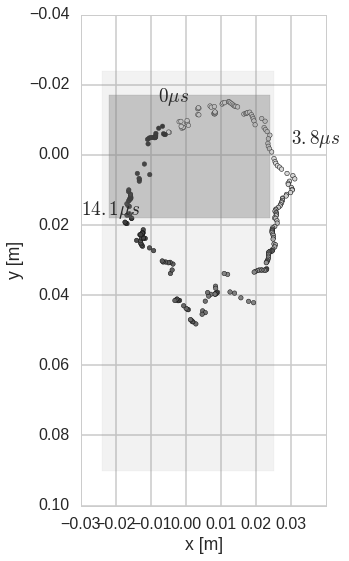

In [15]:
gyration_path()

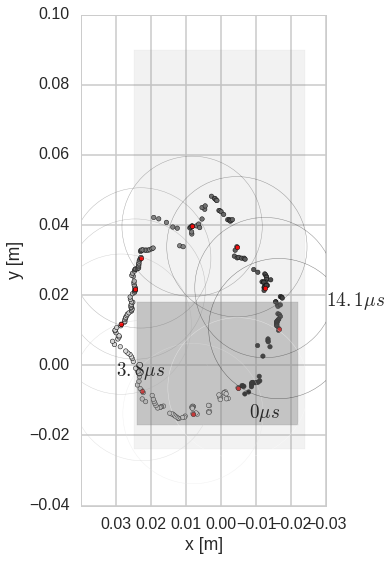

In [7]:
gyration_path(circles=True)

### Develop plots to compare helicities

In [8]:
def compare_helicities(helicities,
                       kinetic=True, relative_kinetic=True,
                       cross=True, relative_cross=True,
                       magnetic=True, relative_magnetic=True,
                       S_0_velocity='u_alfven', normalize=None,
                       nondim=False, absolute=False, 
                       filter_width_cross=None, filter_width_kinetic=None, 
                       add_cross_magnetic=False, add_three=False,
                       ylim=None, labels_case='default', axes=None,
                       scale='linear', patch_ends=True):
    
    assert (scale == 'linear' or scale == 'log' or 
            scale == 'symlog'), "scale must be one of linear, log or symlog" 
    assert (S_0_velocity is None or S_0_velocity == 'u_alfven' or 
            S_0_velocity == 'u_sound'), "S_0_velocity must be one of None, u_alfven, u_sound"
    
    labels = {'kinetic': r'$\mathcal{H}$',
              'relative_kinetic': r'$\mathcal{H}_{rel}$',
              'cross': r'$X$',
              'relative_cross': r'$\mathcal{X}_{rel}$',
              'magnetic': r'$\mathcal{K}$',
              'relative_magnetic': r'$\mathcal{K}_{rel}$'}
    
    labels_dimless = {'kinetic': r'$\bar{\mathcal{H}}$',
                      'relative_kinetic': r'$\bar{\mathcal{H}}_{rel}$',
                      'cross': r'$\bar{\mathcal{X}}$',
                      'relative_cross': r'$\bar{\mathcal{X}}_{rel}$',
                      'magnetic': r'$\bar{\mathcal{K}}$',
                      'relative_magnetic': r'$\bar{\mathcal{K}}_{rel}$'}

    
    labels_dict = {'default': labels, 'dimless': labels_dimless}
    
    labels = labels_dict[labels_case]
    
    m_0 = 1.67e-27 
    q_0 = 1.6e-19
    l_0 = 0.5
    B_0 = 0.02
    u_0_a = 1.4e5
    u_0_cs = 20e3
    
    
    if S_0_velocity == 'u_alfven':
        S_0 = l_0*q_0*B_0/(m_0*u_0_a)        
    elif S_0_velocity == 'u_sound':
        S_0 =  l_0*q_0*B_0/(m_0*u_0_cs)  
    else:
        S_0 = 1.
    
    
    if nondim:
        kinetic_divider = m_0**2 * u_0_a**2 * l_0**2
        cross_divider = m_0*q_0*u_0_a*B_0*l_0**3*1./S_0
        magnetic_divider = q_0**2*B_0**2*l_0**4*1./S_0**2.
    else:
        kinetic_divider = 1. 
        cross_divider = 1.
        magnetic_divider = 1.
    
    if not axes:
        axes = plt.gca()

    time = helicities['time']
    
    keys = helicities.keys()
    keys.remove('time')
    helicities_to_plot = {}
    for key in keys:
        if absolute:
            helicities_to_plot[key] = np.abs(helicities[key])
        else:
            helicities_to_plot[key] = helicities[key]

            

    if normalize:
        norm = np.max(np.abs(helicities_to_plot[normalize]))
        if 'kinetic' in normalize:
            norm /= kinetic_divider
        if 'cross' in normalize:
            norm /= cross_divider
        if 'magnetic' in normalize:
            norm /= magnetic_divider
    else:
        norm = 1

            
    if kinetic:
        axes.plot(time, helicities_to_plot['kinetic']/(norm*kinetic_divider), 
                c='blue', ls='--', label=labels['kinetic'])
    if relative_kinetic:
        if filter_width_kinetic:
            box = boxcar(filter_width_kinetic)/filter_width_kinetic
            signal = np.asarray(helicities_to_plot['relative_kinetic']/(norm*kinetic_divider))
            signal_filt = convolve(signal, box, mode='same')
            kinetic_final = np.asarray(signal_filt)
            axes.plot(time, signal_filt, c='blue', ls='-', label=labels['relative_kinetic'])
            axes.plot(time, signal, 
                      c='blue', alpha=0.2)
        else:
            kinetic_final = helicities_to_plot['relative_kinetic']/(norm*kinetic_divider)
            axes.plot(time, helicities_to_plot['relative_kinetic']/(norm*kinetic_divider), 
                      c='blue', ls='-', label=labels['relative_kinetic'])
    if cross:
        axes.plot(time, helicities_to_plot['cross']/(norm*cross_divider), 
                 c='green', ls='--', label=labels['cross'])
    if relative_cross:
        if filter_width_cross:
            box = boxcar(filter_width_cross)/filter_width_cross
            signal = np.asarray(helicities_to_plot['relative_cross']/(norm*cross_divider))
            signal_filt = convolve(signal, box, mode='same')
            cross_final = np.asarray(signal_filt)
            axes.plot(time, signal_filt, c='green', ls='-', label=labels['relative_cross'])
            axes.plot(time, signal, 
                      c='green', alpha=0.4)
        else:
            cross_final = helicities_to_plot['relative_cross']/(norm*cross_divider)
            axes.plot(time, helicities_to_plot['relative_cross']/(norm*cross_divider), 
                      c='green', ls='-', label=labels['relative_cross'])
    if magnetic:
        axes.plot(time, helicities_to_plot['magnetic']/(norm*magnetic_divider), 
                 c='red', ls='--', label=labels['magnetic'])
    if relative_magnetic:
        magnetic_final = helicities_to_plot['relative_magnetic']/(norm*magnetic_divider)
        axes.plot(time, helicities_to_plot['relative_magnetic']/(norm*magnetic_divider), 
                 c='red', ls='-', label=labels['relative_magnetic'])
    axes.set_xlabel(r'$t$ [$\mu s$]')
    axes.set_yscale(scale)
    axes.set_ylabel(r'$K$ [$J$ $kg$ $m^2$]')
    if normalize:
        axes.set_ylabel(r'$K$ [-]')

    if ylim:
        axes.set_ylim(ylim)
    if add_cross_magnetic:
        axes.plot(time, cross_final + magnetic_final, 
                  c='yellow', ls='-', label=labels['relative_magnetic'] + " $+$ " + labels['relative_cross'])
    if add_three:
        axes.plot(time, kinetic_final + cross_final + magnetic_final, 
                  c='black', ls='-', label=labels['relative_magnetic'] + " $+$ " + labels['relative_cross'] + " $+$ " + labels['relative_kinetic'])
    axes.legend(loc='best', fancybox=True, frameon=True, framealpha=0.9)
    if patch_ends:
        in_box_1 = patches.Rectangle((0, -1000), 3.8, 2000., alpha=0.5, color='grey')
        in_box_2 = patches.Rectangle((14.1, -1000), 19, 2000., alpha=0.5, color='grey')
        axes.add_patch(in_box_1)
        axes.add_patch(in_box_2)
    return axes

#  Gauge Dependent Helicities 

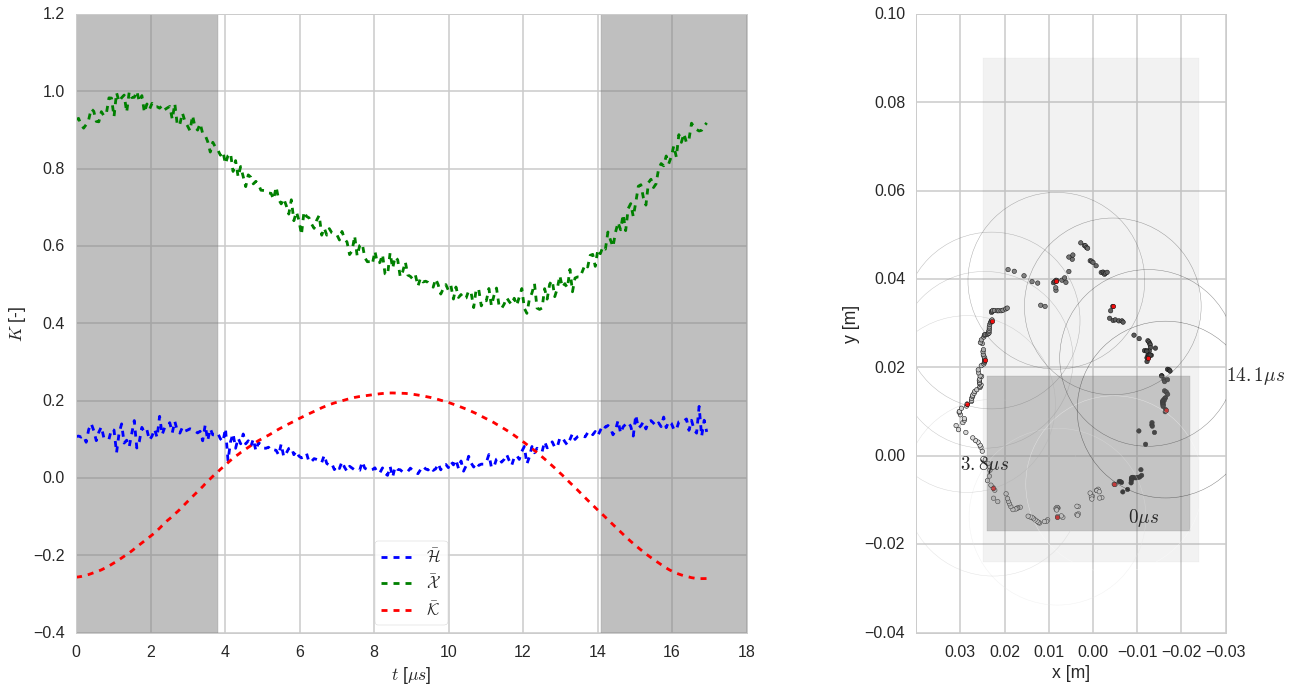

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0] = compare_helicities(helicities, S_0_velocity='u_alfven',
                             nondim=True,
                             labels_case="dimless", 
                             normalize='cross',
                             relative_magnetic=False, relative_kinetic=False, relative_cross=False,
                             axes=axes[0])
axes[1] = gyration_path(axes=axes[1], circles=True)
plt.tight_layout()
plt.show()

# Gauge dependent (dotted) and relative (solid) Helicities 

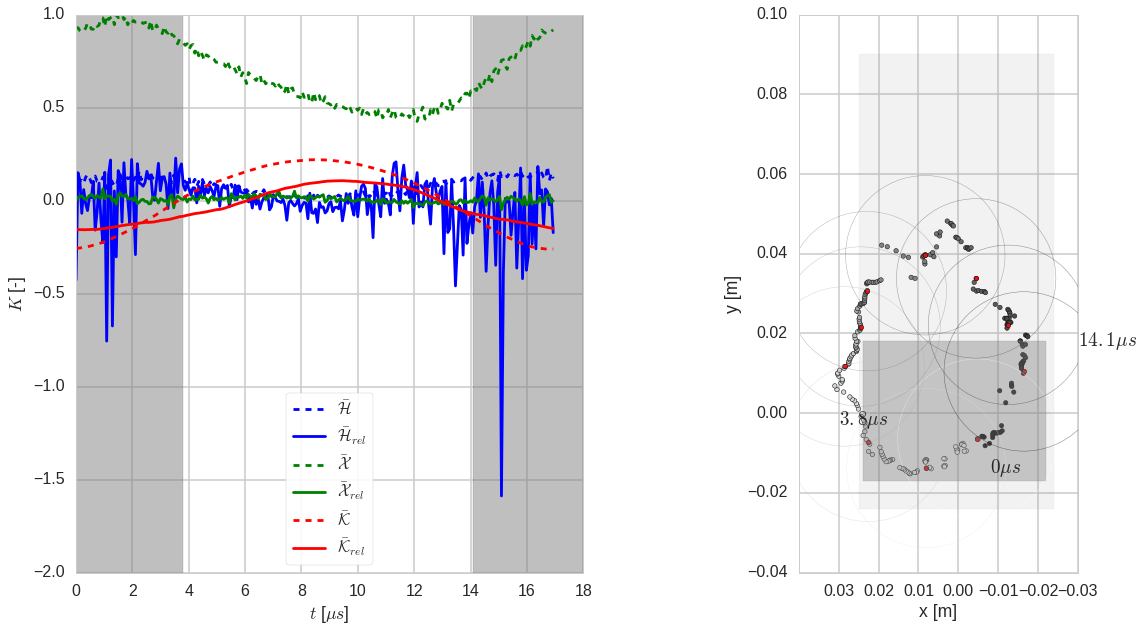

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0] = compare_helicities(helicities, S_0_velocity='u_alfven',
                             labels_case="dimless", 
                             nondim=True,
                             normalize='cross', axes=axes[0])
axes[1] = gyration_path(axes=axes[1], circles=True)
plt.show()

# Plot relative helicity alone

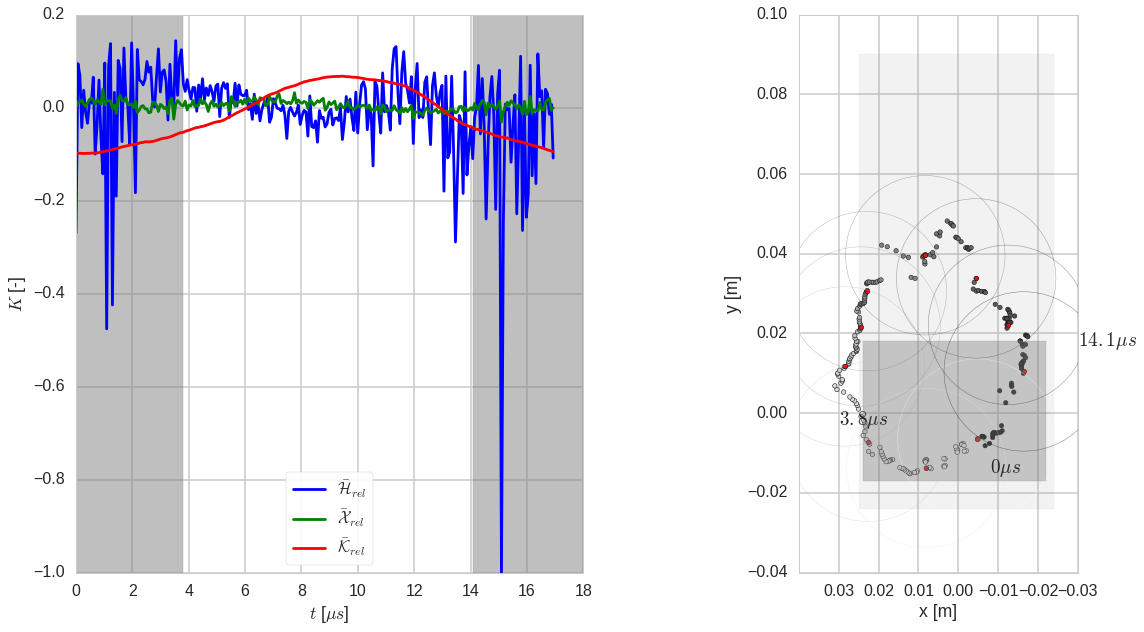

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0] = compare_helicities(helicities, S_0_velocity='u_alfven',
                             labels_case="dimless", 
                             nondim=True,
                             normalize='relative_kinetic',
                             magnetic=False, kinetic=False, cross=False,
                             axes=axes[0])
axes[1] = gyration_path(axes=axes[1], circles=True)
plt.show()

# Filter cross and kinetic helicity

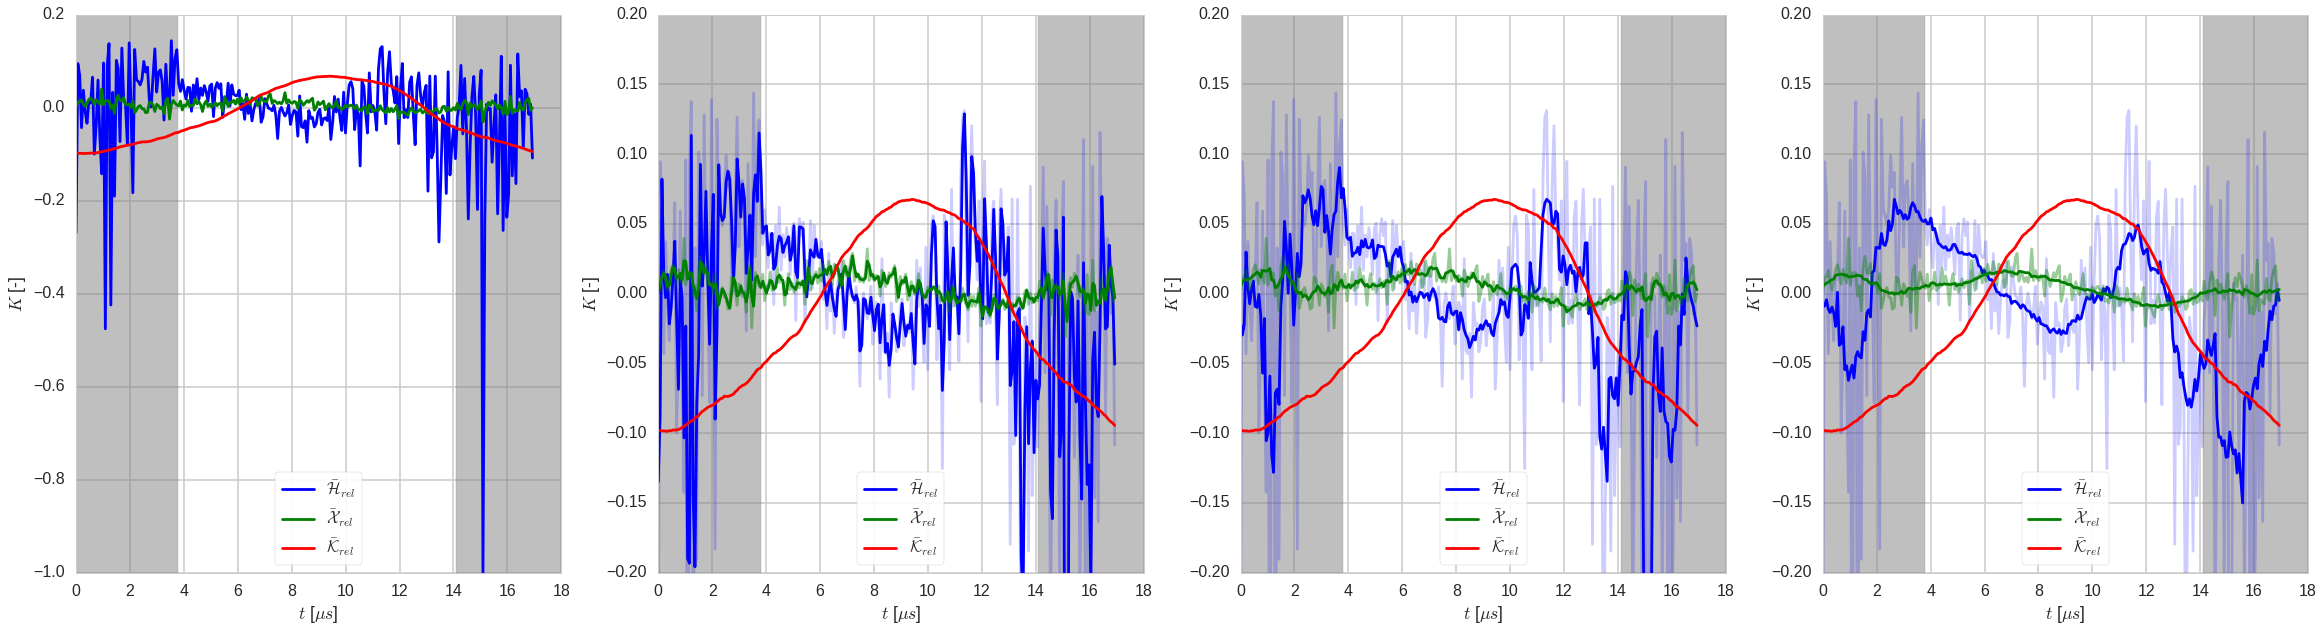

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(40,10))
axes[0] = compare_helicities(helicities,
                             S_0_velocity='u_alfven', 
                             nondim=True,
                             magnetic=False, kinetic=False, cross=False,
                             normalize='relative_kinetic', axes=axes[0],
                             labels_case="dimless")
axes[1] = compare_helicities(helicities, 
                             S_0_velocity='u_alfven',
                             nondim=True,
                             magnetic=False, kinetic=False, cross=False,
                             normalize='relative_kinetic', axes=axes[1],
                             labels_case="dimless",
                             filter_width_kinetic=2, filter_width_cross=2, 
                             ylim=(-0.2, 0.2))
axes[2] = compare_helicities(helicities, 
                             S_0_velocity='u_alfven',
                             nondim=True,
                             magnetic=False, kinetic=False, cross=False,
                             normalize='relative_kinetic', axes=axes[2],
                             labels_case="dimless",
                             filter_width_kinetic=5, filter_width_cross=5,
                             ylim=(-0.2, 0.2))
axes[3] = compare_helicities(helicities, 
                             S_0_velocity='u_alfven',
                             nondim=True,
                             magnetic=False, kinetic=False, cross=False,
                             normalize='relative_kinetic', axes=axes[3],
                             labels_case="dimless",
                             filter_width_kinetic=15, filter_width_cross=15,
                             ylim=(-0.2, 0.2))
plt.show()

# Plot sums of helicity

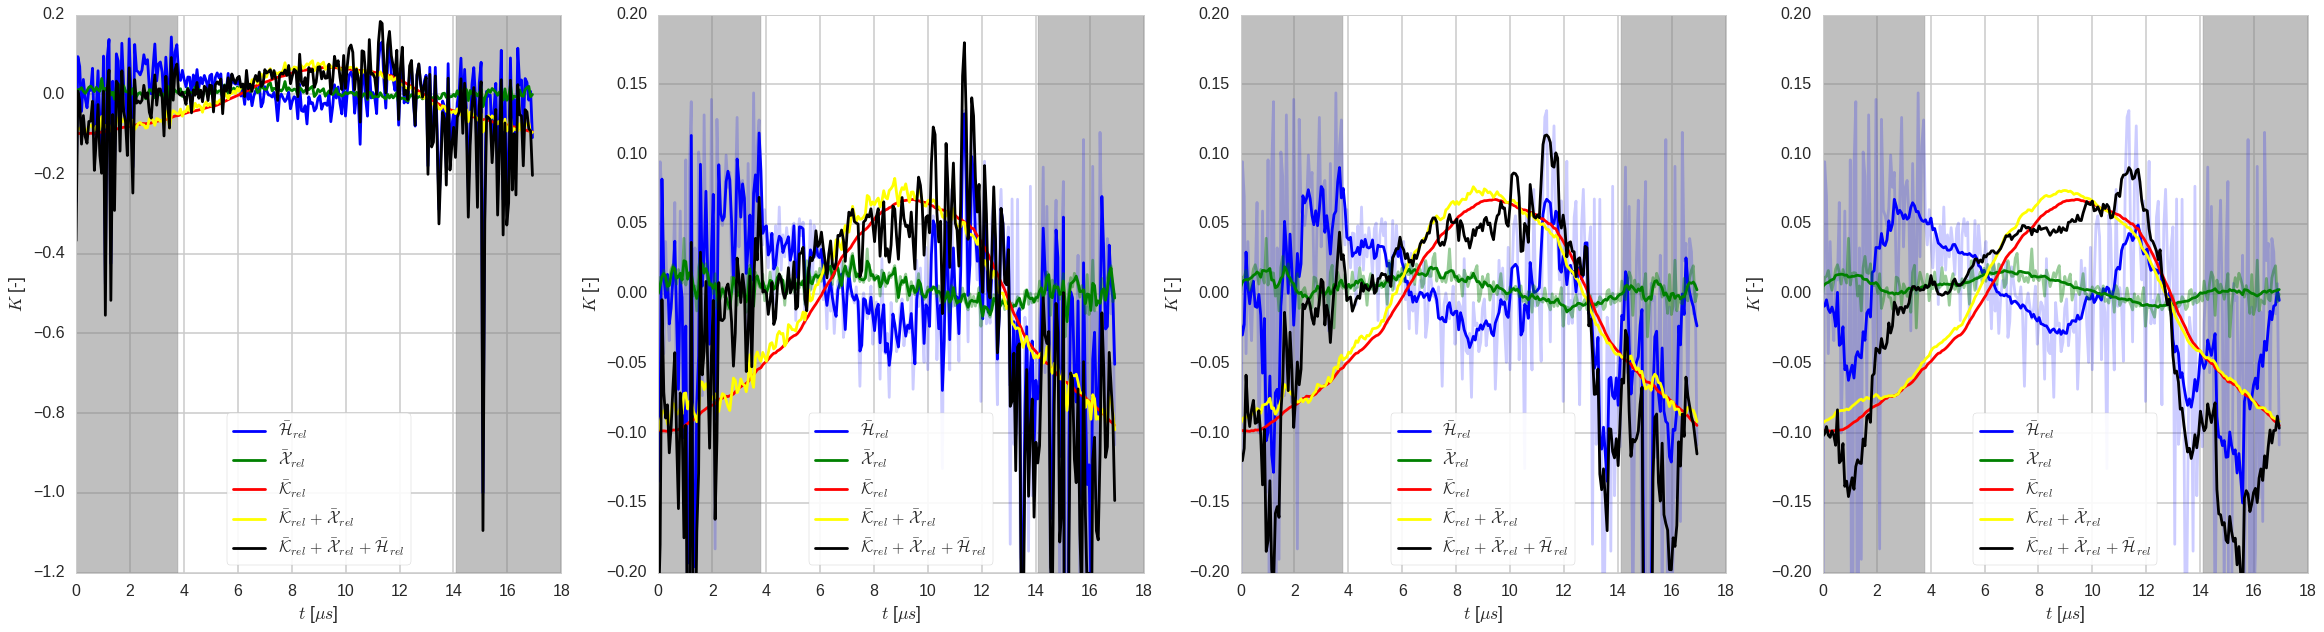

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(40,10))
axes[0] = compare_helicities(helicities,
                             S_0_velocity='u_alfven', 
                             nondim=True,
                             magnetic=False, kinetic=False, cross=False,
                             normalize='relative_kinetic', axes=axes[0],
                             labels_case="dimless",
                             add_cross_magnetic=True, add_three=True)
axes[1] = compare_helicities(helicities, 
                             S_0_velocity='u_alfven',
                             nondim=True,
                             magnetic=False, kinetic=False, cross=False,
                             normalize='relative_kinetic', axes=axes[1],
                             labels_case="dimless",
                             filter_width_kinetic=2, filter_width_cross=2, ylim=(-0.2, 0.2),
                             add_cross_magnetic=True, add_three=True)
axes[2] = compare_helicities(helicities, 
                             S_0_velocity='u_alfven', 
                             nondim=True,
                             magnetic=False, kinetic=False, cross=False,
                             normalize='relative_kinetic', axes=axes[2],
                             labels_case="dimless",
                             filter_width_kinetic=5, filter_width_cross=5, ylim=(-0.2, 0.2),
                             add_cross_magnetic=True, add_three=True)
axes[3] = compare_helicities(helicities, 
                             S_0_velocity='u_alfven',
                             nondim=True,
                             magnetic=False, kinetic=False, cross=False,
                             normalize='relative_kinetic', axes=axes[3],
                             labels_case="dimless",
                             filter_width_kinetic=15, filter_width_cross=15, ylim=(-0.2, 0.2),
                             add_cross_magnetic=True, add_three=True)
plt.show()